In [13]:
import os
import glob
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Cleanup previous files on C drive
previous_output_dir = 'C:/path_to_previous_output_directory'

# Get a list of all .npz files in the directory
npz_files = glob.glob(os.path.join(previous_output_dir, '*.npz'))

# Delete each file
for file in npz_files:
    try:
        os.remove(file)
        print(f"Deleted {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

print("All previous .npz files deleted.")

# Ensure the new output directory exists
output_dir = 'E:/youtube_cosine_sim'
os.makedirs(output_dir, exist_ok=True)

# Download NLTK stopwords (uncomment if not already downloaded)
# nltk.download('stopwords')

# Load the dataset (adjust the path accordingly)
df = pd.read_csv('GB_youtube_trending_data.csv')

# Clean and preprocess the dataset
df.drop_duplicates(subset=['video_id'], inplace=True)
if 'description' in df.columns:
    df.dropna(subset=['description'], inplace=True)

if 'publishedAt' in df.columns:
    df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
if 'trending_date' in df.columns:
    df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')

str_columns = ['title', 'channelTitle', 'tags', 'description']
for col in str_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

if 'comments_disabled' in df.columns:
    df['comments_disabled'] = df['comments_disabled'].astype(bool)
if 'ratings_disabled' in df.columns:
    df['ratings_disabled'] = df['ratings_disabled'].astype(bool)

# Save cleaned DataFrame to CSV (optional)
df.to_csv('cleaned_GB_youtube_trending_data.csv', index=False)

# Preprocess tags for similarity analysis
stop_words = set(stopwords.words('english'))

def preprocess_tags(tags):
    # Split tags by comma and join into a single string of words
    tag_words = ' '.join(tags.split(','))
    # Convert to lowercase, remove punctuation, and remove stopwords
    tag_words = tag_words.lower()
    tag_words = ''.join([char for char in tag_words if char not in string.punctuation])
    tag_words = ' '.join([word for word in tag_words.split() if word not in stop_words])
    return tag_words

df['cleaned_tags'] = df['tags'].apply(preprocess_tags)

# Compute TF-IDF matrix with limited features for tags
tfidf_vectorizer_tags = TfidfVectorizer(max_features=10000)  # Limit the number of features
tfidf_matrix_tags = tfidf_vectorizer_tags.fit_transform(df['cleaned_tags'])

# Use sparse matrix
tfidf_matrix_tags = csr_matrix(tfidf_matrix_tags)

# Compute truncated SVD on TF-IDF matrix for tags
svd_tags = TruncatedSVD(n_components=100)  # Further reduce dimensions
tfidf_matrix_tags_reduced = svd_tags.fit_transform(tfidf_matrix_tags)

# Clear memory
del tfidf_matrix_tags

# Batch processing for cosine similarity based on tags
batch_size = 1000  # Adjust batch size as needed
num_samples = tfidf_matrix_tags_reduced.shape[0]
top_n = 10  # Number of top similar items to store

for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    cosine_sim_batch_tags = cosine_similarity(tfidf_matrix_tags_reduced[start:end, :], tfidf_matrix_tags_reduced)
    
    # Only keep top N similarities for each item
    top_similarities_tags = np.zeros((end - start, top_n))
    top_indices_tags = np.zeros((end - start, top_n), dtype=int)
    for i in range(end - start):
        top_n_indices_tags = np.argsort(cosine_sim_batch_tags[i])[-top_n:]
        top_indices_tags[i] = top_n_indices_tags
        top_similarities_tags[i] = cosine_sim_batch_tags[i, top_n_indices_tags]

    np.savez(f'{output_dir}/cosine_sim_top_tags_{start}_{end}.npz', top_similarities=top_similarities_tags, top_indices=top_indices_tags)

# Load all top similarities and concatenate
all_similarities_tags = []
all_indices_tags = []
for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    data_tags = np.load(f'{output_dir}/cosine_sim_top_tags_{start}_{end}.npz')
    all_similarities_tags.append(data_tags['top_similarities'])
    all_indices_tags.append(data_tags['top_indices'])

all_similarities_tags = np.vstack(all_similarities_tags)
all_indices_tags = np.vstack(all_indices_tags)

# Create DataFrame to display similarity scores based on tags
similarity_df_tags = pd.DataFrame(index=df['tags'], columns=range(top_n))

for i, tags in enumerate(df['tags']):
    similar_tags = df['tags'].iloc[all_indices_tags[i]].values
    similarity_df_tags.iloc[i] = similar_tags

# Display a subset of the similarity matrix based on tags
print(similarity_df_tags.head(10))  # Display top 10x10 part of the similarity matrix

# Example: Find most similar tags to the first tag in the DataFrame
first_tag = df['tags'].iloc[0]
similar_tags = similarity_df_tags.iloc[0]
print(f"\nMost similar tags to '{first_tag}':")
print(similar_tags.head(10))

# Function to predict view count based on user-submitted tags
def predict_view_count_tags(user_tags, df, tfidf_vectorizer_tags, svd_tags, similarity_df_tags):
    predicted_view_counts_tags = []
    
    for user_tag in user_tags:
        user_tag_processed = preprocess_tags(user_tag)
        user_tag_tfidf = tfidf_vectorizer_tags.transform([user_tag_processed])
        
        # Transform using SVD
        user_tag_reduced = svd_tags.transform(user_tag_tfidf)
        
        # Compute cosine similarities based on tags
        similarities_tags = cosine_similarity(user_tag_reduced, tfidf_matrix_tags_reduced)
        similar_indices_tags = np.argsort(similarities_tags[0])[::-1][:10]  # Top 10 similar tags
        
        # Retrieve view counts of similar tags
        similar_view_counts_tags = df.iloc[similar_indices_tags]['view_count']
        
        # Calculate predicted view count based on tags
        predicted_view_count_tags = similar_view_counts_tags.mean()
        predicted_view_counts_tags.append(predicted_view_count_tags)
    
    return predicted_view_counts_tags

# Example user-submitted tags
user_tags = [
    "python programming, machine learning, data science",
    "travel, budget, tips, adventure",
    "cooking, recipes, beginners, food",
    "fitness, health, lifestyle, workout",
    "fashion, trends, summer, 2024",
    "movies, rainy day, entertainment",
    "finance, planning, professionals, money"
]

# Predict view counts for user-submitted tags
predicted_view_counts_tags = predict_view_count_tags(user_tags, df, tfidf_vectorizer_tags, svd_tags, similarity_df_tags)

# Plotting the predicted view counts based on tags
plt.figure(figsize=(12, 8))
plt.barh(user_tags, predicted_view_counts_tags, color='skyblue')
plt.xlabel('Predicted View Count')
plt.title('Predicted Popularity of User-Submitted Tags')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest prediction at the top
plt.tight_layout()
plt.show()

# Preprocess titles for similarity analysis
def preprocess_title(title):
    # Convert to lowercase, remove punctuation, and remove stopwords
    title = title.lower()
    title = ''.join([char for char in title if char not in string.punctuation])
    title = ' '.join([word for word in title.split() if word not in stop_words])
    return title

df['cleaned_title'] = df['title'].apply(preprocess_title)

# Compute TF-IDF matrix with limited features for titles
tfidf_vectorizer_titles = TfidfVectorizer(max_features=10000)  # Limit the number of features
tfidf_matrix_titles = tfidf_vectorizer_titles.fit_transform(df['cleaned_title'])

# Use sparse matrix
tfidf_matrix_titles = csr_matrix(tfidf_matrix_titles)

# Compute truncated SVD on TF-IDF matrix for titles
svd_titles = TruncatedSVD(n_components=100)  # Further reduce dimensions
tfidf_matrix_titles_reduced = svd_titles.fit_transform(tfidf_matrix_titles)

# Clear memory
del tfidf_matrix_titles

batch_size_titles = 1000  # Adjust batch size as needed
num_samples_titles = tfidf_matrix_titles_reduced.shape[0]
top_n_titles = 10  # Number of top similar items to store

for start in range(0, num_samples_titles, batch_size_titles):
    end = min(start + batch_size_titles, num_samples_titles)
    cosine_sim_batch_titles = cosine_similarity(tfidf_matrix_titles_reduced[start:end, :], tfidf_matrix_titles_reduced)
    
    # Only keep top N similarities for each item
    top_similarities_titles = np.zeros((end - start, top_n_titles))
    top_indices_titles = np.zeros((end - start, top_n_titles), dtype=int)
    for i in range(end - start):
        top_n_indices_titles = np.argsort(cosine_sim_batch_titles[i])[-top_n_titles:]
        top_indices_titles[i] = top_n_indices_titles
        top_similarities_titles[i] = cosine_sim_batch_titles[i, top_n_indices_titles]

    np.savez(f'{output_dir}/cosine_sim_top_titles_{start}_{end}.npz', top_similarities=top_similarities_titles, top_indices=top_indices_titles)


# Load all top similarities and concatenate
all_similarities_titles = []
all_indices_titles = []
for start in range(0, num_samples_titles, batch_size_titles):
    end = min(start + batch_size_titles, num_samples_titles)
    data_titles = np.load(f'{output_dir}/cosine_sim_top_titles_{start}_{end}.npz')
    all_similarities_titles.append(data_titles['top_similarities'])
    all_indices_titles.append(data_titles['top_indices'])

all_similarities_titles = np.vstack(all_similarities_titles)
all_indices_titles = np.vstack(all_indices_titles)

# Create DataFrame to display similarity scores based on titles
similarity_df_titles = pd.DataFrame(index=df['title'], columns=range(top_n_titles))

for i, title in enumerate(df['title']):
    similar_titles = df['title'].iloc[all_indices_titles[i]].values
    similarity_df_titles.iloc[i] = similar_titles

# Display a subset of the similarity matrix based on titles
print(similarity_df_titles.head(10))  # Display top 10x10 part of the similarity matrix

# Example: Find most similar titles to the first title in the DataFrame
first_title = df['title'].iloc[0]
similar_titles = similarity_df_titles.iloc[0]
print(f"\nMost similar titles to '{first_title}':")
print(similar_titles.head(10))

# Function to predict view count based on user-submitted titles
def predict_view_count_titles(user_titles, df, tfidf_vectorizer_titles, svd_titles, similarity_df_titles):
    predicted_view_counts_titles = []
    
    for user_title in user_titles:
        user_title_processed = preprocess_title(user_title)
        user_title_tfidf = tfidf_vectorizer_titles.transform([user_title_processed])
        
        # Transform using SVD
        user_title_reduced = svd_titles.transform(user_title_tfidf)
        
        # Compute cosine similarities based on titles
        similarities_titles = cosine_similarity(user_title_reduced, tfidf_matrix_titles_reduced)
        similar_indices_titles = np.argsort(similarities_titles[0])[::-1][:10]  # Top 10 similar titles
        
        # Retrieve view counts of similar titles
        similar_view_counts_titles = df.iloc[similar_indices_titles]['view_count']
        
        # Calculate predicted view count based on titles
        predicted_view_count_titles = similar_view_counts_titles.mean()
        predicted_view_counts_titles.append(predicted_view_count_titles)
    
    return predicted_view_counts_titles

# Example user-submitted titles
user_titles = [
    "Python for Beginners | Full Course",
    "Budget Travel Tips | Ultimate Guide",
    "Delicious and Easy Recipes for Beginners",
    "10-Minute Home Workout | No Equipment",
    "2024 Fashion Trends | What's In and Out",
    "Best Movies to Watch on a Rainy Day",
    "Financial Planning for Professionals | Tips and Advice"
]

# Predict view counts for user-submitted titles
predicted_view_counts_titles = predict_view_count_titles(user_titles, df, tfidf_vectorizer_titles, svd_titles, similarity_df_titles)

# Plotting the predicted view counts based on titles
plt.figure(figsize=(12, 8))
plt.barh(user_titles, predicted_view_counts_titles, color='lightcoral')
plt.xlabel('Predicted View Count')
plt.title('Predicted Popularity of User-Submitted Titles')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest prediction at the top
plt.tight_layout()
plt.show()

# Example user-submitted tags
user_tags = [
    "python programming, machine learning, data science",
    "travel, budget, tips, adventure",
    "cooking, recipes, beginners, food",
    "fitness, health, lifestyle, workout",
    "fashion, trends, summer, 2024",
    "movies, rainy day, entertainment",
    "finance, planning, professionals, money"
]

# Filter DataFrame for tags that match user-submitted tags
tag_indices = df['tags'].apply(lambda tags: any(tag in tags for tag in user_tags))
tag_df = df[tag_indices]

# Check if there are any rows in tag_df
if not tag_df.empty:
    # Compute cosine similarity for the user-submitted tags
    tfidf_matrix_tags_user = tfidf_vectorizer_tags.transform(tag_df['cleaned_tags'])
    tfidf_matrix_tags_user_reduced = svd_tags.transform(tfidf_matrix_tags_user)
    cosine_sim_user_tags = cosine_similarity(tfidf_matrix_tags_user_reduced, tfidf_matrix_tags_reduced)

    # Sort and get top similarities
    top_indices_user_tags = np.argsort(cosine_sim_user_tags[:, :], axis=1)[:, -top_n:]
    top_similarities_user_tags = cosine_sim_user_tags[:, top_indices_user_tags]

    # Plotting all user-submitted tags on a single graph
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_similarities_user_tags.flatten(), y=user_tags, palette='viridis')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('User-Submitted Tags')
    plt.title('Top Similar Titles for User-Submitted Tags')
    plt.xlim(0, 1)  # Adjust xlim based on cosine similarity range (0 to 1)
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest similarity at the top
    plt.tight_layout()
    plt.show()
else:
    print("No matching tags found in the dataset.")

All previous .npz files deleted.


KeyboardInterrupt: 

c:\Users\ellio\Python\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\ellio\AppData\Local\Temp\ipykernel_15920\2757154438.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'log_view_count'] = np.log(df_filtered['view_count'])
C:\Users\ellio\AppData\Local\Temp\ipykernel_15920\2757154438.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

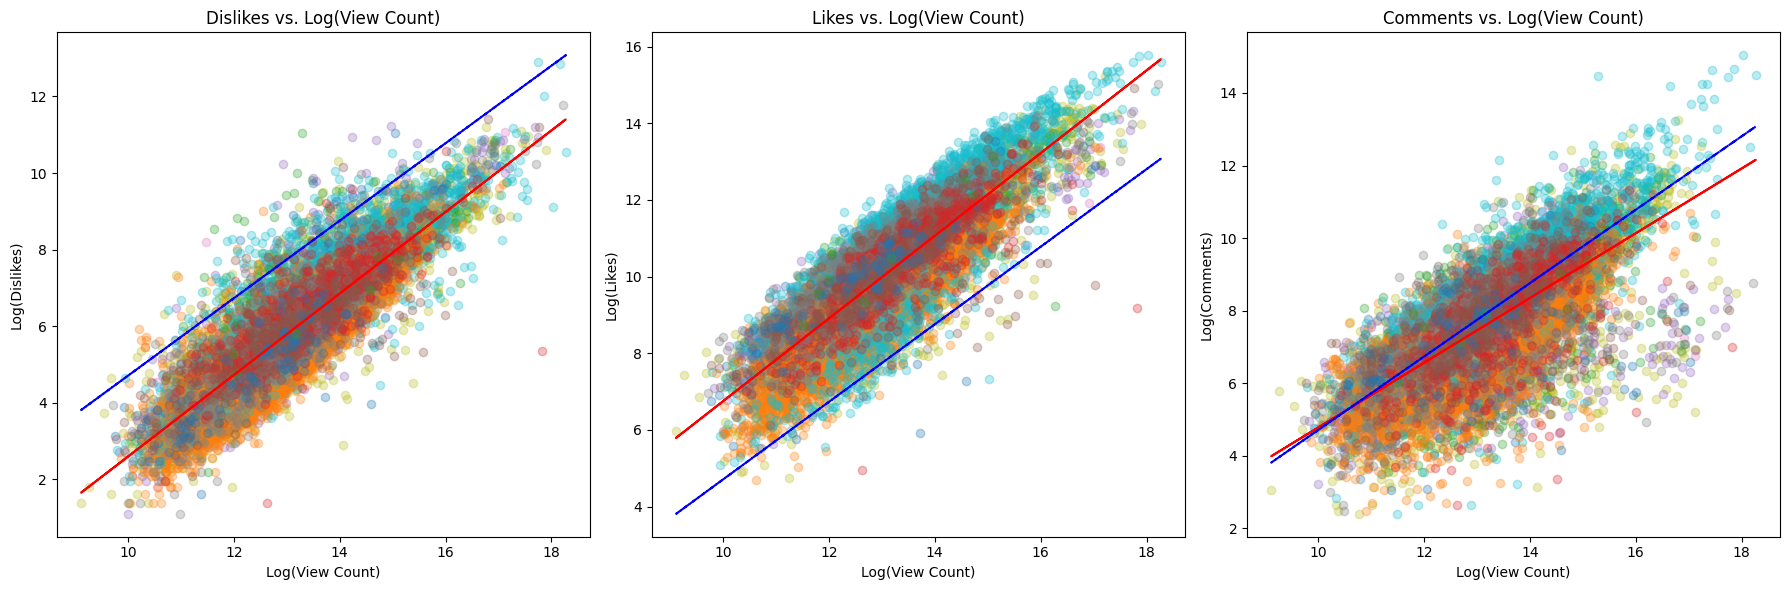

Minimum values:
view_count       9097
likes             109
dislikes            3
comment_count      11
dtype: int64

Maximum values:
view_count       85890366
likes             7110087
dislikes           405347
comment_count     3402401
dtype: int64

Row with maximum view_count:
           video_id                         title           publishedAt  \
266393  cc2-4ci4G84  Discord Loot Boxes are here.  2024-04-01T17:46:17Z   

                       channelId channelTitle  categoryId  \
266393  UCZ5XnGb-3t7jCkXdawN2tkA      Discord          24   

               trending_date    tags  view_count   likes  dislikes  \
266393  2024-04-04T00:00:00Z  [None]  1406329649  165173         0   

        comment_count                                  thumbnail_link  \
266393          17446  https://i.ytimg.com/vi/cc2-4ci4G84/default.jpg   

        comments_disabled  ratings_disabled  \
266393              False             False   

                                              description  
26

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Load pre-trained model for semantic similarity
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to calculate semantic similarity between category names
def calculate_similarity(cat_name1, cat_name2):
    # Encode category names into embeddings
    embeddings = model.encode([cat_name1, cat_name2])
    # Calculate cosine similarity between embeddings
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity

# Load the dataset
df = pd.read_csv('GB_youtube_trending_data.csv')

# Clean dataset if needed (remove duplicates, handle missing values)
df.drop_duplicates(subset=['video_id'], inplace=True)
df.dropna(subset=['view_count', 'likes', 'dislikes', 'comment_count'], inplace=True)

# Filter based on conditions: likes > 10, comments enabled and > 10, ratings not disabled
df_filtered = df[(df['likes'] > 10) & 
                 (df['comments_disabled'] == False) & 
                 (df['comment_count'] > 10) & 
                 (df['ratings_disabled'] == False) &
                 (df['view_count'] > 10)]  # Filter out view_count = 0

# Log transformation for view_count, likes, comments, and dislikes
df_filtered.loc[:, 'log_view_count'] = np.log(df_filtered['view_count'])
df_filtered.loc[:, 'log_likes'] = np.log(df_filtered['likes'])
df_filtered.loc[:, 'log_comment_count'] = np.log(df_filtered['comment_count'])
df_filtered.loc[:, 'log_dislikes'] = np.log(df_filtered['dislikes'] + 1)  # Adding 1 to handle log(0)

# Filter out videos with no dislikes
df_filtered_dislikes = df_filtered[df_filtered['dislikes'] > 0]
df_filtered_dislikes.loc[:, 'log_dislikes'] = np.log(df_filtered_dislikes['dislikes'])

# Calculate pairwise similarities between category names
category_names = df_filtered_dislikes['categoryId'].unique()
num_categories = len(category_names)
similarity_matrix = np.zeros((num_categories, num_categories))

for i, cat_name1 in enumerate(category_names):
    for j, cat_name2 in enumerate(category_names):
        similarity_matrix[i, j] = calculate_similarity(str(cat_name1), str(cat_name2))

# Define colormap based on similarity matrix
colors = plt.cm.tab10(np.linspace(0, 1, len(category_names)))
similarity_order = np.argsort(np.sum(similarity_matrix, axis=0))
similarity_colors = [colors[i] for i in similarity_order]

# Create figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for dislikes vs. log(view count)
for i, cat_name in enumerate(category_names):
    df_cat = df_filtered_dislikes[df_filtered_dislikes['categoryId'] == cat_name]
    ax1.scatter(df_cat['log_view_count'], df_cat['log_dislikes'], alpha=0.3, color=similarity_colors[i], label=f'{cat_name}')

ax1.set_title('Dislikes vs. Log(View Count)')
ax1.set_xlabel('Log(View Count)')
ax1.set_ylabel('Log(Dislikes)')

# Fit linear regression model for dislikes
model_dislikes = LinearRegression()
X_dislikes = df_filtered_dislikes['log_view_count'].values.reshape(-1, 1)
y_dislikes = df_filtered_dislikes['log_dislikes']
model_dislikes.fit(X_dislikes, y_dislikes)
ax1.plot(df_filtered_dislikes['log_view_count'], model_dislikes.predict(X_dislikes), color='red', label='Linear Regression')

# Scatter plot for likes vs. log(view count)
for i, cat_name in enumerate(category_names):
    df_cat = df_filtered_dislikes[df_filtered_dislikes['categoryId'] == cat_name]
    ax2.scatter(df_cat['log_view_count'], df_cat['log_likes'], alpha=0.3, color=similarity_colors[i], label=f'{cat_name}')

ax2.set_title('Likes vs. Log(View Count)')
ax2.set_xlabel('Log(View Count)')
ax2.set_ylabel('Log(Likes)')

# Fit linear regression model for likes
model_likes = LinearRegression()
X_likes = df_filtered_dislikes['log_view_count'].values.reshape(-1, 1)
y_likes = df_filtered_dislikes['log_likes']
model_likes.fit(X_likes, y_likes)
ax2.plot(df_filtered_dislikes['log_view_count'], model_likes.predict(X_likes), color='red', label='Linear Regression')

# Scatter plot for comments vs. log(view count)
for i, cat_name in enumerate(category_names):
    df_cat = df_filtered_dislikes[df_filtered_dislikes['categoryId'] == cat_name]
    ax3.scatter(df_cat['log_view_count'], df_cat['log_comment_count'], alpha=0.3, color=similarity_colors[i], label=f'{cat_name}')

ax3.set_title('Comments vs. Log(View Count)')
ax3.set_xlabel('Log(View Count)')
ax3.set_ylabel('Log(Comments)')

# Fit linear regression model for comments
model_comments = LinearRegression()
X_comments = df_filtered_dislikes['log_view_count'].values.reshape(-1, 1)
y_comments = df_filtered_dislikes['log_comment_count']
model_comments.fit(X_comments, y_comments)
ax3.plot(df_filtered_dislikes['log_view_count'], model_comments.predict(X_comments), color='red', label='Linear Regression')

# Aggregate the regression lines for comparison
aggregate_regression = (model_dislikes.predict(X_dislikes) + model_likes.predict(X_likes) + model_comments.predict(X_comments)) / 3
ax1.plot(df_filtered_dislikes['log_view_count'], aggregate_regression, color='blue', linestyle='--', label='Aggregate Regression')
ax2.plot(df_filtered_dislikes['log_view_count'], aggregate_regression, color='blue', linestyle='--', label='Aggregate Regression')
ax3.plot(df_filtered_dislikes['log_view_count'], aggregate_regression, color='blue', linestyle='--', label='Aggregate Regression')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Output the filtered dataframe for evaluation
df_filtered_output = df_filtered_dislikes.copy()

# Calculate minimum and maximum values
min_values = df_filtered_output[['view_count', 'likes', 'dislikes', 'comment_count']].min()
max_values = df_filtered_output[['view_count', 'likes', 'dislikes', 'comment_count']].max()

# Print the results
print("Minimum values:")
print(min_values)
print("\nMaximum values:")
print(max_values)

# Find the row with maximum view_count
max_view_count_row = df[df['view_count'] == df['view_count'].max()]
print("\nRow with maximum view_count:")
print(max_view_count_row)


C:\Users\ellio\AppData\Local\Temp\ipykernel_15920\3733527988.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'log_view_count'] = np.log(df_filtered['view_count'])
C:\Users\ellio\AppData\Local\Temp\ipykernel_15920\3733527988.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'log_likes'] = np.log(df_filtered['likes'])
C:\Users\ellio\AppData\Local\Temp\ipykernel_15920\3733527988.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Coefficient for log_view_count (Dislikes): 1.065000780844495
Coefficient for log_view_count (Likes): 1.0792868444864883
Coefficient for log_view_count (Comments): 0.8927851963250156
R-squared (Dislikes): 0.7423891885022349
R-squared (Likes): 0.7191000062586879
R-squared (Comments): 0.5312733621112475


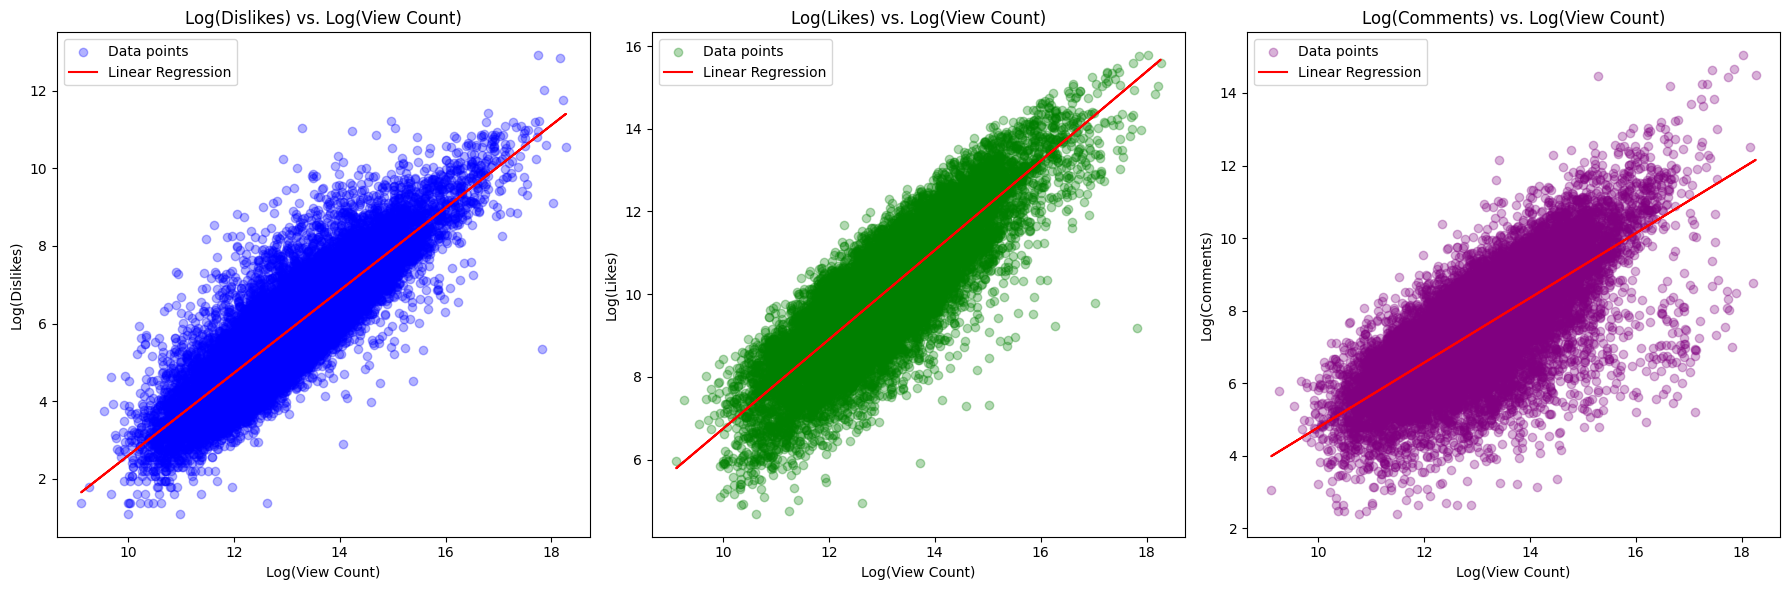

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the dataset
df = pd.read_csv('GB_youtube_trending_data.csv')

# Clean dataset if needed (remove duplicates, handle missing values)
df.drop_duplicates(subset=['video_id'], inplace=True)
df.dropna(subset=['view_count', 'likes', 'dislikes', 'comment_count'], inplace=True)

# Filter based on conditions: likes > 10, comments enabled and > 10, ratings not disabled
df_filtered = df[(df['likes'] > 10) & 
                 (df['comments_disabled'] == False) & 
                 (df['comment_count'] > 10) & 
                 (df['ratings_disabled'] == False) &
                 (df['view_count'] > 10)]  # Filter out view_count = 0

# Log transformation for view_count, likes, comments, and dislikes
df_filtered.loc[:, 'log_view_count'] = np.log(df_filtered['view_count'])
df_filtered.loc[:, 'log_likes'] = np.log(df_filtered['likes'])
df_filtered.loc[:, 'log_comment_count'] = np.log(df_filtered['comment_count'])
df_filtered.loc[:, 'log_dislikes'] = np.log(df_filtered['dislikes'] + 1)  # Adding 1 to handle log(0)

# Filter out videos with no dislikes
df_filtered_dislikes = df_filtered[df_filtered['dislikes'] > 0]
df_filtered_dislikes.loc[:, 'log_dislikes'] = np.log(df_filtered_dislikes['dislikes'])

# Define features (X) and target variables (y)
X = df_filtered_dislikes[['log_view_count']]
y_dislikes = df_filtered_dislikes['log_dislikes']
y_likes = df_filtered_dislikes['log_likes']
y_comments = df_filtered_dislikes['log_comment_count']

# Initialize linear regression models
model_dislikes = LinearRegression()
model_likes = LinearRegression()
model_comments = LinearRegression()

# Fit models
model_dislikes.fit(X, y_dislikes)
model_likes.fit(X, y_likes)
model_comments.fit(X, y_comments)

# Print coefficients (feature importance)
print("Coefficient for log_view_count (Dislikes):", model_dislikes.coef_[0])
print("Coefficient for log_view_count (Likes):", model_likes.coef_[0])
print("Coefficient for log_view_count (Comments):", model_comments.coef_[0])

# Create figure and axes for feature importance visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plotting feature importance
ax1.bar(['log_view_count'], [model_dislikes.coef_[0]], color='b', label='Dislikes')
ax1.set_title('Feature Importance: Log(Dislikes)')
ax1.set_ylabel('Coefficient')
ax1.legend()

ax2.bar(['log_view_count'], [model_likes.coef_[0]], color='g', label='Likes')
ax2.set_title('Feature Importance: Log(Likes)')
ax2.set_ylabel('Coefficient')
ax2.legend()

ax3.bar(['log_view_count'], [model_comments.coef_[0]], color='purple', label='Comments')
ax3.set_title('Feature Importance: Log(Comments)')
ax3.set_ylabel('Coefficient')
ax3.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
